In [1]:
import sys
import os

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import cross_validation

import LightFM_model
from LightFM_model import LightFM
from Data_preprocessing import Dataset

""" Import LightFM's evaluation metrics """
from evaluation_metrics_at_k2 import precision_at_k 
from evaluation_metrics_at_k2 import recall_at_k
from evaluation_metrics_at_k import precision_at_k as lightfm_prec_at_k
from evaluation_metrics_at_k import recall_at_k as lightfm_recall_at_k

from lightfm_utils import (track_model_metrics, prepare_test_df, prepare_all_predictions,
                          compare_metric, similar_users, similar_items)

from IPython.display import display, Math, Latex
from IPython.display import Image

C:\Users\teflo\OneDrive\Desktop\light_fm\light_fm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Types of Recommender Systems

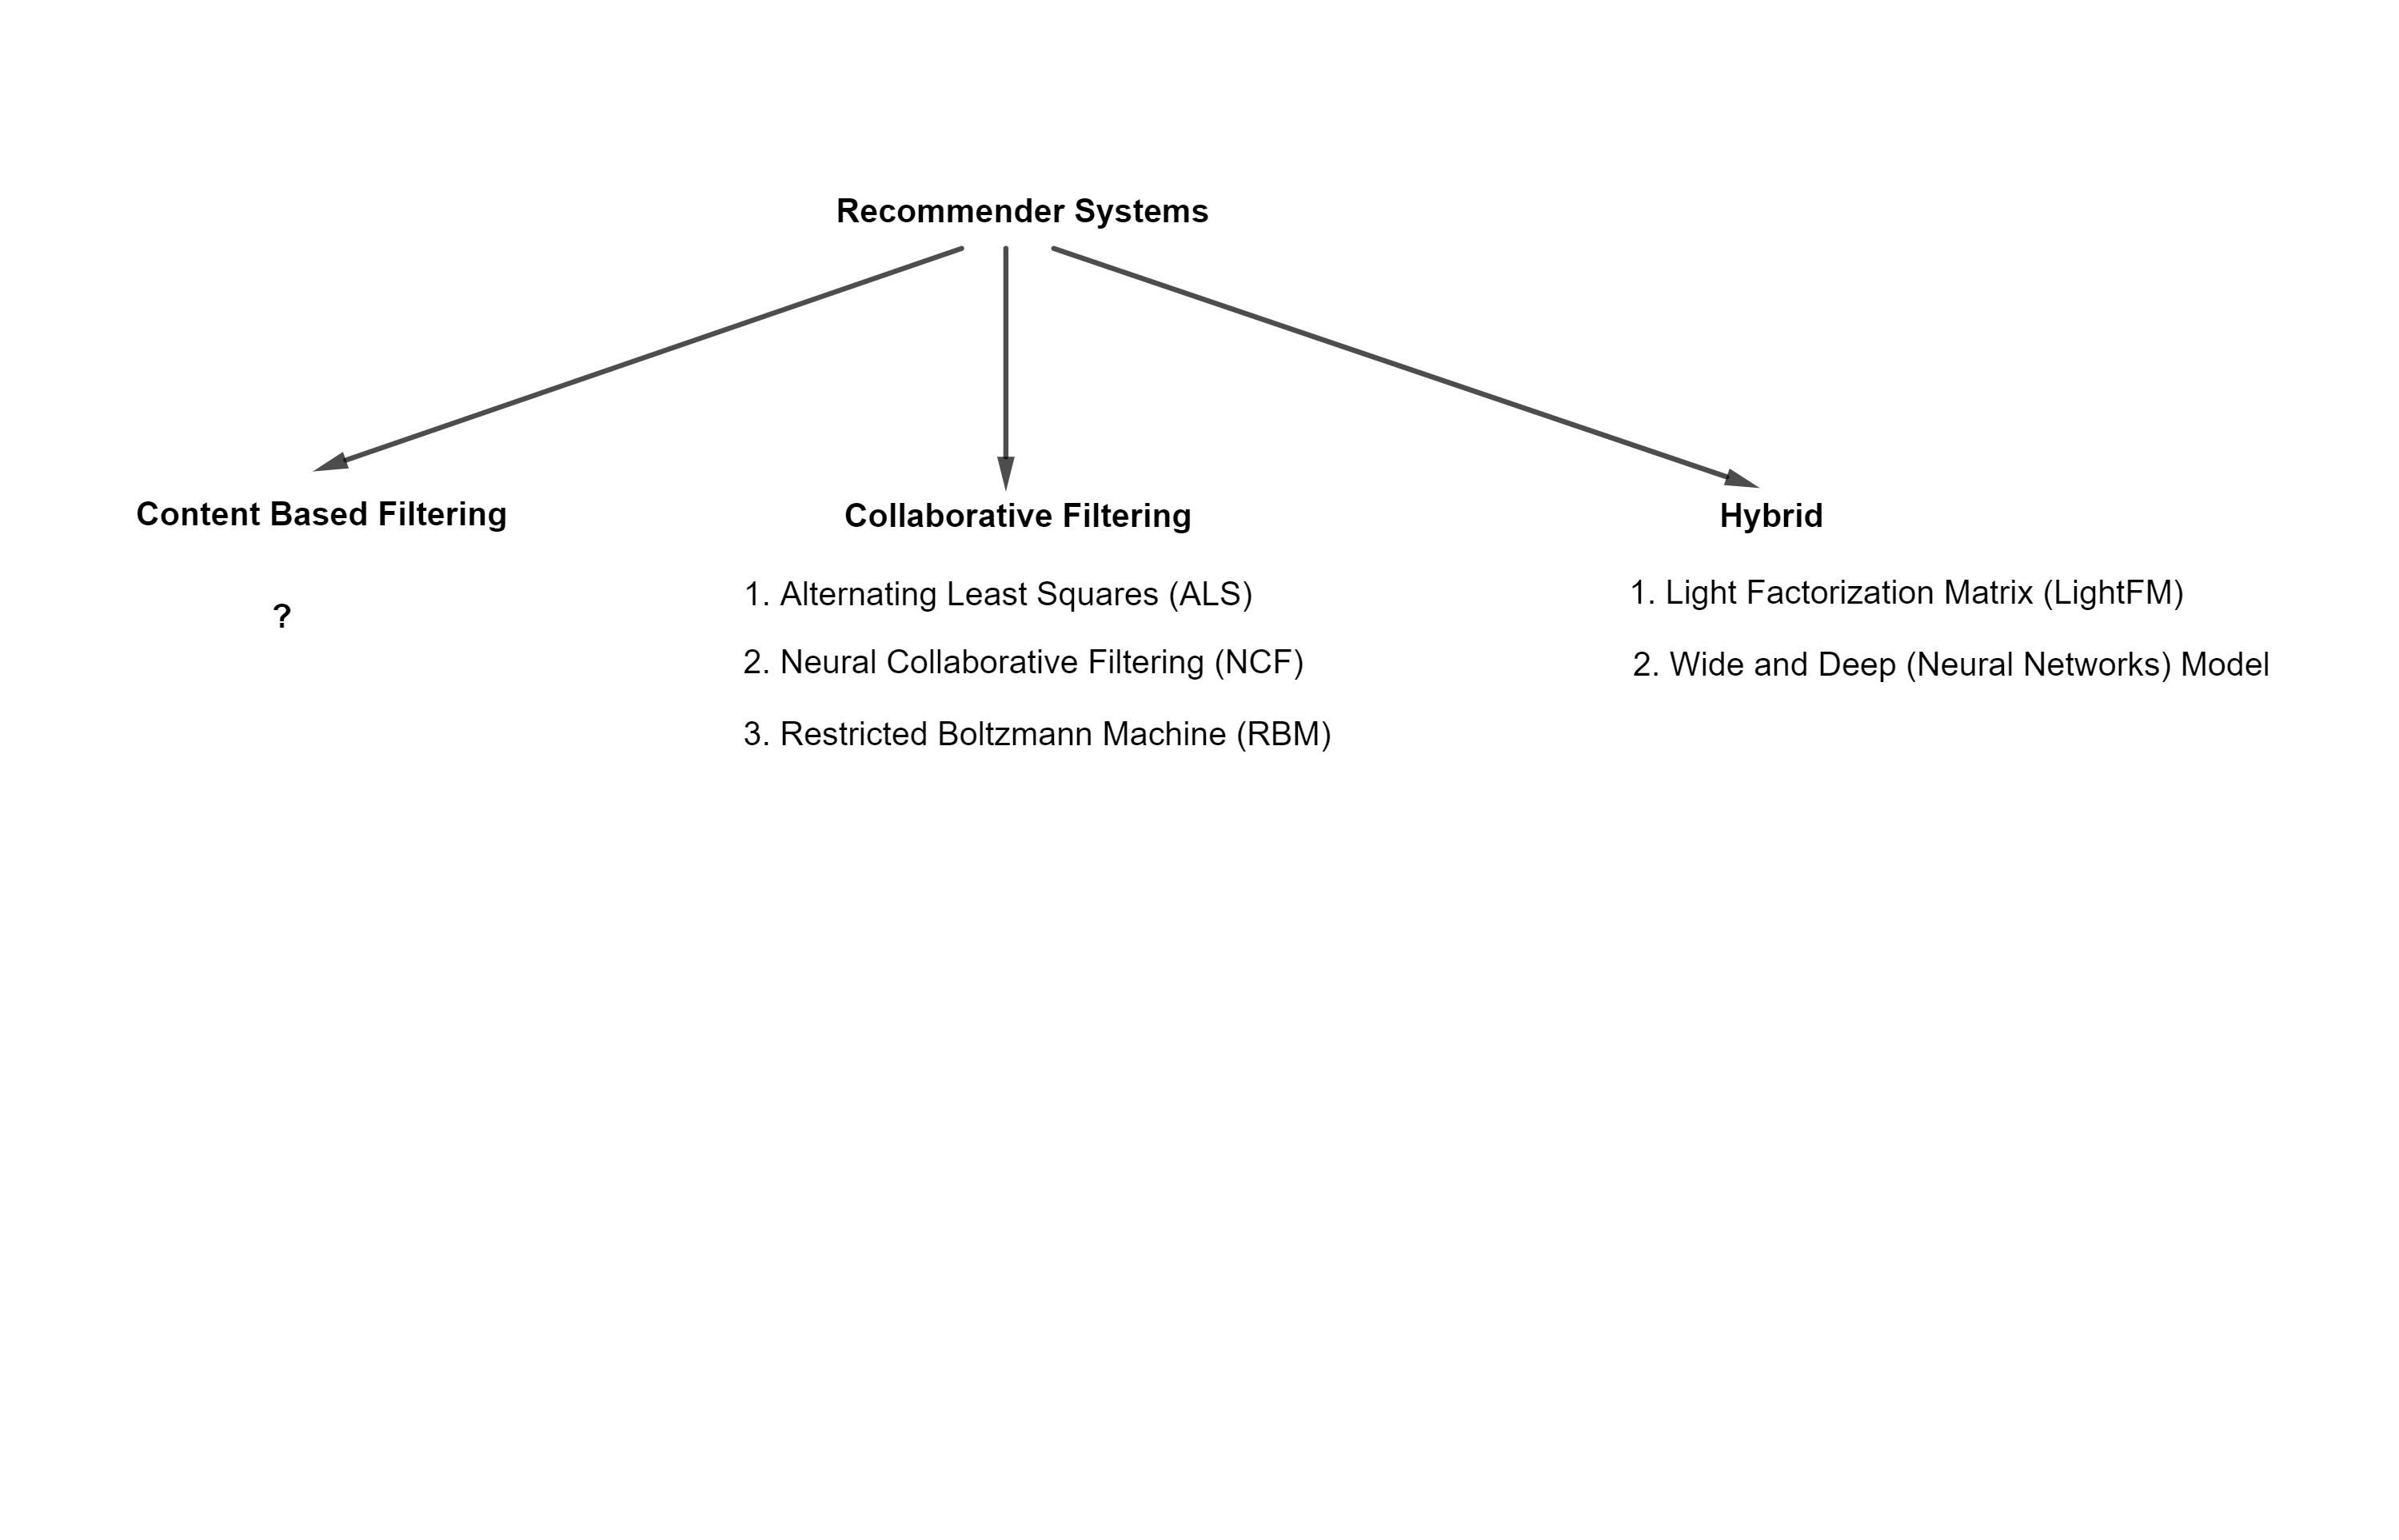

In [2]:
Image(filename='geogebra2-export.png',width=900, height=600)

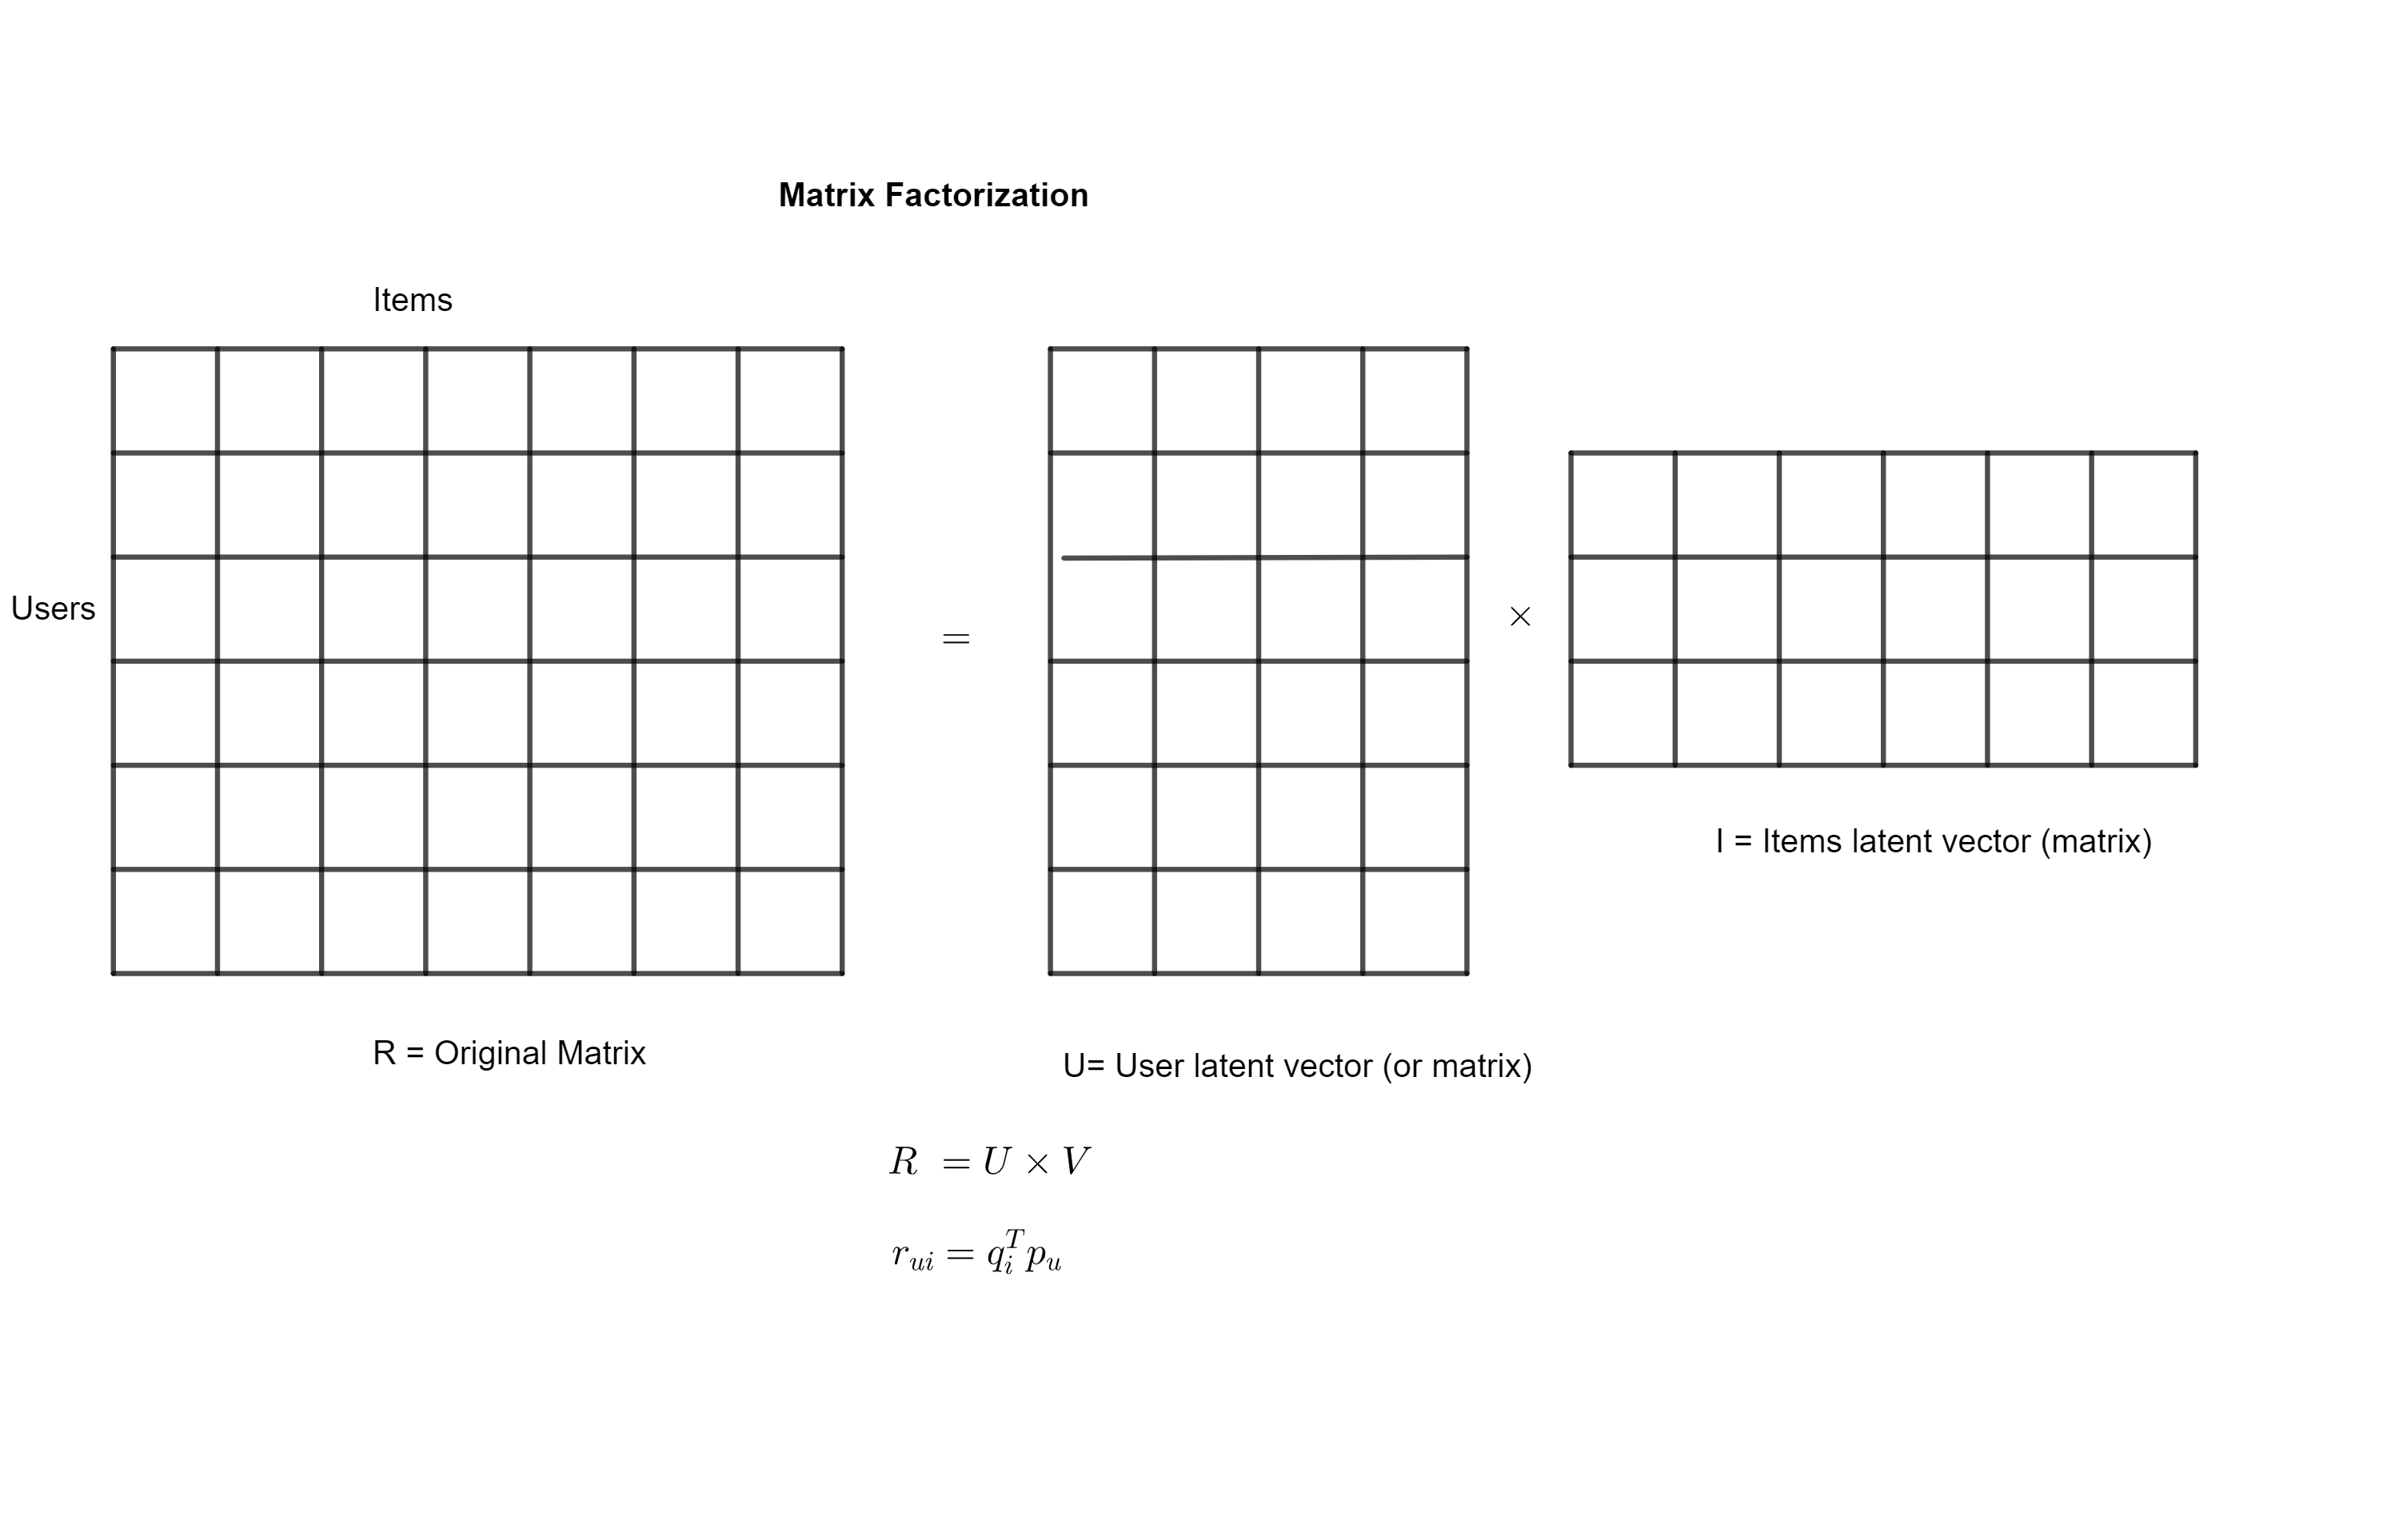

In [3]:
Image(filename='geogebra-export.png',width=900, height=600)

### Comparison between ALS and Light Factorization Matrix (LightFM)

The matrix factorization of the ALS model is given as follows,

\begin{align}
\hat{r}_{u,i}=q_i^Tp_u
\end{align}

where $r_{ui}$ is the predicting ratings for the user $u$ and item $i$, while $q_i^T$ and $p_u$ are the latent factors for the item $i$ and user $u$ respectively. The learning approach or optimization goal is to find the optimum (best) matrix decomposition for the latent vectors $q_i^T$ and $p_u$ that give the closest rating $r_{ui}$ values. The learning or loss function is shown below, the aim of learning (also known as training) is to find the minimum of this function (loss function),

\begin{align}
min\sum (r_{u,i}-q_i^Tp_u)^2+\lambda(||q_i||^2+||p_u||^2)
\end{align}

where $\lambda$ is the regularized parameter. The above function is for modelling implicit ratings and for the explicit ratings, one uses,

\begin{align}
min\sum c_{u,i}(r_{u,i}-q_i^Tp_u)^2+\lambda(||q_i||^2+||p_u||^2)
\end{align}

where $r_{ui}$ will be the number of clicks, and $c_{u,i}=1+\alpha r_{u,i}$

For learning or minimizing the above function the Gradient Descent optimization method can be used, but it will be expensive since the function is non-convex, therefore an Alternating Least Squares (ALS) algorithm is used. ALS optimization algorithm works by learning either $q$ or $p$ at a time while holding the other $q$ or $p$ constant, then it altenates the learning and holding of $p$ and $q$ at the next iteration. The ALS model through matrix factorization and dot product between latent vectors is able the learn or capture the linear interaction of the dataset between the user and the item, non-linear interaction between user and item relation is not propery learned or captured. The LightFM model, which is also a matrix factorization model has the advantage that it is able to capture non-linear interactions in the dataset, provided there is one. It is able to do this by combining the user and items as linear combinations of their content features.

### Light Factorization Matrix (LightFM)

The prediction or rating of user $u$ and item $i$ is modelled as a sigmoid function containig inside its argument a dot product of user and item vectors plus the feature biases as shown below
\begin{align}
\hat{r}_{ui}=\sigma(q_u\cdot p_i+b_u+b_i)
\end{align}

where $q_u$ and $p_i$ are embedding latent vectors/representations of user $u$ and item $i$ respectively, the sum of the features of latent vectors is as follows,

\begin{align}
q_u=\sum_{j\in f_u}e^{U}_j\\
p_i=\sum_{j\in f_i}e^{I}_j
\end{align}

Whereas $b_u$ and $b_i$ are bias terms for user $u$ and item $i$ features, given as follows,

\begin{align}
b_u=\sum_{j\in f_u}e_j^U\\
b_i=\sum_{j\in f_i} e_j^I
\end{align}

The cost function or loss function used for computing the error for training and finding the optimum weights (during optimization using stochastic gradient descent) is the likelihood function,

\begin{align}
L=\prod_{(u,i)\in S_+}\hat{r}_{ui}\times \prod_{(u,i)\in S_-}(1-\hat{r}_{ui})
\end{align}

In [4]:
data = pd.read_excel(r'C:.\movielens.xlsx')

In [5]:
print(data)

       userID  itemID  rating        genre
0         196     242       3       Comedy
1          63     242       3       Comedy
2         226     242       5       Comedy
3         154     242       3       Comedy
4         306     242       5       Comedy
...       ...     ...     ...          ...
99995     840    1674       4        Drama
99996     655    1640       3        Drama
99997     655    1637       3        Drama
99998     655    1630       3        Drama
99999     655    1641       3  Documentary

[100000 rows x 4 columns]


In [6]:
data_2 = pd.read_excel(r'C:.\movielens_2.xlsx')
print(data_2)

     userID  age gender     occupation zipcode
0         1   24      M     technician   85711
1         2   53      F          other   94043
2         3   23      M         writer   32067
3         4   24      M     technician   43537
4         5   33      F          other   15213
..      ...  ...    ...            ...     ...
938     939   26      F        student   33319
939     940   32      M  administrator   02215
940     941   20      M        student   97229
941     942   48      F      librarian   78209
942     943   22      M        student   77841

[943 rows x 5 columns]


In [7]:
class Data_preparation:
    
    def __init__(self,
                 data,
                 learning_rate,
                 no_epochs,
                 no_components,
                 no_threads,
                 k,
                 test_percentage = 0.25,
                 interactions = None, 
                 weights = None, 
                 dataset = None):
        
        """
        Constructor
        
        Args:
        
        data (pandas)           : Input data.
        learning_rate (float)   : Model learning rate.
        no_epochs (int)         : Number of epochs (period/time) for model training.
        no_components (int)     : Number of latent factors.
        no_threads (int)        : Number of threads or CPU cores used for model training.
        k (int)                 : Number of top k recommendations.
        test_percentage (float) : Percentage to be of test dataset.
        interactions (array)    : Interaction matrix sourced from the user-item rating data/table.
        weights (array)         : Weight matrix sourced from  the user-item rating data/table.
        dataset (pandas)        : Empty dataset used to information at in between the code.
        
        """
        self.data            = data
        self.learning_rate   = learning_rate
        self.no_epochs       = no_epochs
        self.no_components   = no_components
        self.no_threads      = no_threads
        self.k               = k
        self.test_percentage = test_percentage
        self.interactions    = None
        self.weights         = None
        self.dataset         = None

    def user_item_dimensions(self):
        
        """
        Function or method to preprocess the dataset using the Dataset() function imported from the
        Data_preprocessing module.
           
        Return: The function or method returns the pre-processed dataset as self.dataset which is stored as an attribute
        for later use, initially self.dataset is None.
           
        """
        
        self.dataset = Dataset()
        
        self.dataset.fit(users=self.data['userID'], items=self.data['itemID'])
        
        num_users, num_topics = self.dataset.interactions_shape()
        
        print('Number of users: {}'.format(num_users), 'number of topics: {}'.format(num_topics))
        
        return(self.dataset)
    
    def interaction_matrix(self): 
        
        """
        Method or function to generate the interaction matrix from the original dataset.
        Return: both the interaction matrix and the weights which are stored as attributes for later use.
        
        """
        
        if self.dataset is None:
            self.dataset = self.user_item_dimensions()
        
            self.interactions, self.weights = self.dataset.build_interactions(self.data.iloc[:, 0:3].values)
        
        return self.interactions, self.weights
    
    
    def train_test_matrix(self):
        
        """
        Method or function for splitting the interaction dataset into train and test and also for generating
        the train and test weights.
        
        Return: The function returns training and test dataset with their respectives train and test weights
        
        """
        
  #      interactions, weights = self.interaction_matrix()
        
        self.train_int, self.test_int = cross_validation.random_train_test_split(self.interactions, 
                                                test_percentage=self.test_percentage, random_state=np.random.RandomState(SEED))
        
        self.train_weights, self.test_weights = cross_validation.random_train_test_split(self.weights, 
                                        test_percentage=self.test_percentage, random_state=np.random.RandomState(SEED))
        
        print("Shape of train interactions: {}".format(self.train_int.shape))
        print("Shape of test interactions: {}".format(self.test_int.shape))
        
        return(self.train_int, self.test_int, self.train_weights, self.test_weights)
    
    @classmethod
    def from_str_parameters(cls, string_parameters):
        pass
    
    @property
    def get_parameters(self):
        print("Getting and showing parameters")
        a = self.learning_rate   
        b = self.no_epochs       
        c = self.no_components  
        d = self.no_threads      
        e = self.k           
        
        return "learning_rate:{}, no_epochs:{}, no_components:{}, no_threads:{}, top_k:{}".format(a,b,c,d,e)
    
    @get_parameters.setter
    def get_parameters(self, array):
        print("Setting new parameters")
        a,b,c,d,e = array.split(" ")
        self.learning_rate = a
        self.no_epochs = b
        self.no_components = c
        self.no_threads = d
        self.k = e
        
        

In [8]:
class Model_building(Data_preparation): 
    
    """
    
    Separate class method for model building.
    Inheriting methods (functions) from the Data_preparation parent class)"""
    
    def __init__(self,
                 data,
                 learning_rate,
                 no_epochs,
                 no_components,
                 no_threads,
                 k,
                 test_percentage=0.25,
                 interactions=None, 
                 weights=None):
        
        super().__init__(data,
                         learning_rate, no_epochs, 
                         no_components,
                         no_threads,
                         k,
                         test_percentage=0.25,
                         interactions=None, 
                         weights=None)

        
    def model_fitting(self):
        
        """
        Method or function for fitting the lightfm model.
        The model uses the weighted Approximate-Rank Pairwise (WARP) as the loss.
        Return: The function returns the fitted lightfm model which will be used later in the mapping method
        or function.
        
        """
            
        model = LightFM(no_components=self.no_components, learning_rate=self.learning_rate ,loss="warp", random_state=2019)
        model = model.fit(self.interactions, epochs=self.no_components ,num_threads=self.no_threads)
        
        return(model)
    
    
    def mapping(self):
        
        """
        Function or method for mapping user_id and item_id, after that the mapping predction package is used
        for making prediction on the test dataset.
        
        Return: The function returns the both the test dataset and the predicted results.
        """
        model = self.model_fitting()
        interactions, weights = self.interaction_matrix()
        
        uids, iids, interaction_data = cross_validation._shuffle(self.interactions.row, self.interactions.col, 
                                                        self.interactions.data, random_state=np.random.RandomState(SEED))
        
        train_int, _, _, _, = self.train_test_matrix()
        
 
        self.dataset.fit(users=self.data['userID'], items=self.data['itemID'])
        uid_map, ufeature_map, iid_map, ifeature_map = self.dataset.mapping()
        
        cutoff = int((1.0 - self.test_percentage) * len(uids))
        test_idx = slice(cutoff, None)
        
        test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
        all_predictions = prepare_all_predictions(self.data, uid_map, iid_map, interactions=self.train_int,
                                              model=model, num_threads=self.no_threads)
        
        return(test_df, all_predictions)
    
    
    def evaluation_metrics(self):
        
        """
        Method or function to compute the evaluation metrics, so far only the precision and recall at k
        metrics are computed, other evaluation metrics can be easily added when the need arises.
        Return: The  function returns the recall and precision at k results.
        
        """
 
        model = self.model_fitting()
        eval_precision_lfm = lightfm_prec_at_k(model, self.test_int, 
                                           self.train_int, k=self.k).mean()
        eval_recall_lfm = lightfm_recall_at_k(model, self.test_int, 
                                          self.train_int, k=self.k).mean()
        print("Precision: {}".format(eval_precision_lfm), "Recall: {}".format(eval_recall_lfm))

In [9]:
class Model_building_features(Data_preparation):
    
    """ Class model building including item and user features """
    
    def __init__(self,
                 data,
                 learning_rate,
                 no_epochs ,
                 no_components,
                 no_threads,
                 k,
                 test_percentage=0.25,
                 interactions=None, 
                 weights=None):
    
        super().__init__(data, 
                         learning_rate, 
                         no_epochs,
                         no_components,
                         no_threads,
                         k,
                         test_percentage=0.25, 
                         interactions=None, 
                         weights=None)
        
    def interaction_matrix(self, df):
        
        """all_movie_genre"""
        user_data = df
        
        movie_genre = [x.split('|') for x in self.data['genre']]
        """retrieve the all the unique genres in the data"""
        all_movie_genre = sorted(list(set(itertools.chain.from_iterable(movie_genre))))
        """"Checking at the all the genres within the data"""
        
        """all_movie_genre"""
        #user_data = df

        """merging user feature with existing data"""
        new_data = self.data.merge(user_data[['userID','occupation']], left_on='userID', right_on='userID')
        """" quick look at the merged data"""
                     
        
        all_occupations = sorted(list(set(new_data['occupation'])))
        self.dataset = Dataset()
        self.dataset.fit(self.data['userID'], self.data['itemID'], item_features=all_movie_genre, user_features=all_occupations)
        self.item_features = self.dataset.build_item_features((x, y) for x,y in zip(data.itemID, movie_genre))
        self.user_features = self.dataset.build_user_features((x, [y]) for x,y in zip(new_data.userID, new_data['occupation']))
        
        self.interactions, self.weights = self.dataset.build_interactions(self.data.iloc[:, 0:3].values)
        
        return(self.user_features, self.item_features)
        
        
    def train_test_matrix(self):
        
        self.train_int, self.test_int = cross_validation.random_train_test_split(self.interactions, 
                                            test_percentage=self.test_percentage ,random_state=np.random.RandomState(SEED))
        
        return(self.train_int, self.test_int)
        
        
    def model_fitting(self): 
        
        """Class method for fitting the model"""
        
        self.model2 = LightFM(loss='warp', no_components=self.no_components, learning_rate=self.learning_rate, 
                    item_alpha=ITEM_ALPHA, user_alpha=USER_ALPHA, random_state=np.random.RandomState(SEED))
        
        self.model2.fit(interactions=self.train_int, user_features=self.user_features, item_features=self.item_features,
                      epochs=self.no_epochs)
        
        return(self.model2)
        
    def mapping(self):
        
        uids, iids, interaction_data = cross_validation._shuffle(self.interactions.row, self.interactions.col, 
                                                                 self.interactions.data, 
                                                                 random_state=np.random.RandomState(SEED))  
        
        
        cutoff = int((1.0 - self.test_percentage) * len(uids))
        test_idx = slice(cutoff, None)
        
        uid_map, ufeature_map, iid_map, ifeature_map = self.dataset.mapping()
        
        test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, self.weights)
        
        all_predictions2 = prepare_all_predictions(self.data, uid_map, iid_map, interactions=self.train_int,
                                               user_features=self.user_features,
                                               item_features=self.item_features,
                                               model=self.model2,
                                               num_threads=self.no_threads)
        
        eval_precision2 = precision_at_k(rating_true=test_df2, rating_pred=all_predictions2, k=self.k)
        eval_recall2 = recall_at_k(test_df2, all_predictions2, k=self.k)
        
        print("Precison score: {}".format(eval_precision2), "Recall score: {}".format(eval_recall2))        

In [10]:
""" Method to get top 10 users similar to the specific user_id"""
def get_similar_users(self, user):
    
    user_id = user
    model = self.model_fitting()
    similarity = similar_users(user_id=user_id, user_features=self.user_features, model=model)
    
    return(similarity)

# Integrating or glueing the method with the Data_prep method
Data_preparation.get_similar_users=get_similar_users

In [11]:
# Method to get top 10 items similar to the specific item_id
def get_similar_items(self, item):
    
    item_id = item
    model = self.model_fitting()
    similarity = similar_items(item_id=item_id, item_features=self.item_features, model=model)
    
    return(similarity)

Data_preparation.get_similar_items=get_similar_items

In [12]:
"""regularisation for both user and item features"""
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6
"""seed for pseudonumber generations"""
SEED = 42

### Run the model

In [13]:
lightfm =  Model_building(data, 0.25, 20, 20, 10, 32)
lightfm.interaction_matrix()
lightfm.model_fitting()

Number of users: 943 number of topics: 1682


In [14]:
lightfm.mapping()

Shape of train interactions: (943, 1682)
Shape of test interactions: (943, 1682)


(       userID  itemID  rating
 0         160     952     4.0
 1          83      88     5.0
 2         617    1019     4.0
 3         345     246     4.0
 4         387      95     2.0
 ...       ...     ...     ...
 24995     500     304     2.0
 24996     902       8     5.0
 24997     630     411     4.0
 24998     234     265     3.0
 24999      26     685     3.0
 
 [25000 rows x 3 columns],
          userID  itemID  prediction
 0           196     302    5.708856
 1           196     377  -23.658552
 2           196      51   -6.006684
 3           196     346  -33.375187
 4           196     474   11.634360
 ...         ...     ...         ...
 1511121     873    1674   -0.755342
 1511122     873    1640  -43.930656
 1511123     873    1637  -50.793915
 1511124     873    1630  -42.814842
 1511125     873    1641  -65.099648
 
 [1511126 rows x 3 columns])

In [15]:
lightfm.evaluation_metrics()

Precision: 0.1744101345539093 Recall: 0.20051195913877165


In [16]:
lightfm_2 = Model_building_features(data, 0.25, 20, 20, 32, 10)

In [17]:
lightfm_2.interaction_matrix(data_2)

(<943x964 sparse matrix of type '<class 'numpy.float32'>'
 	with 1886 stored elements in Compressed Sparse Row format>,
 <1682x1701 sparse matrix of type '<class 'numpy.float32'>'
 	with 4575 stored elements in Compressed Sparse Row format>)

In [18]:
lightfm_2.train_test_matrix()

(<943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 75000 stored elements in COOrdinate format>,
 <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 25000 stored elements in COOrdinate format>)

In [19]:
lightfm_2.model_fitting()

In [20]:
lightfm_2.mapping()

Precison score: 0.14856839872746555 Recall score: 0.055854396855922826


In [21]:
lightfm_2.get_similar_users(1)

userID     score
0     555  1.000000
1      54  0.999999
2     314  0.999999
3     395  0.999998
4     465  0.999998
5     527  0.999998
6     481  0.999997
7     282  0.999996
8     855  0.999994
9     411  0.999994

In [22]:
lightfm_2.get_similar_items(10)

itemID     score
0      12  0.999272
1     231  0.999271
2     182  0.999253
3     474  0.999240
4      76  0.999208
5     253  0.999204
6     296  0.999149
7     573  0.999139
8     458  0.999108
9     628  0.998951